In [1]:
import jaydebeapi
from ibmdbpy import IdaDataBase
from ibmdbpy import IdaDataFrame
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json

In [2]:
import os
import jpype

os.environ['CLASSPATH'] = "/usr/local/src/data-connectors-1.4.1/db2jcc4-10.5.0.6.jar"
args='-Djava.class.path=%s' % os.environ['CLASSPATH']
jvm = jpype.getDefaultJVMPath()
jpype.startJVM(jvm, args)

In [3]:
dsn_uid = "bluadmin";  # e.g.  db104434
dsn_pwd = "MTAwMGZhZmMxYTc4"   # e.g. xxxx
dsn_hostname ="dashdb-txn-flex-yp-dal10-21.services.dal.bluemix.net"  # e.g.  awh-yp-small03.services.dal.bluemix.net
dsn_port = "50000"   # e.g.  50001
dsn_database = "BLUDB"   # e.g. BLUDB 

connection_string='jdbc:db2://'+dsn_hostname+':'+dsn_port+'/'+dsn_database+':user='+dsn_uid+';password='+dsn_pwd+";" 
idadb=IdaDataBase(dsn=connection_string)

In [4]:
#idadf = IdaDataFrame(idadb, 'BLUADMIN.NW_DATA_SET_PER_01092018')
#idadf1 = IdaDataFrame(idadb, 'BLUADMIN.DATA_SET_LATENCY_01092018')
#idadf2 = IdaDataFrame(idadb, 'BLUADMIN.NW_DATA_SET_NW_INFO_01092018')
idadf = IdaDataFrame(idadb, 'BLUADMIN.PER_TEST_SG')
idadf1 = IdaDataFrame(idadb, 'BLUADMIN.LATENCY_TEST_SG')
idadf2 = IdaDataFrame(idadb, 'BLUADMIN.NWINFO_TEST_SG')

In [5]:
START= pd.Timestamp('2018-01-23 21:00:00');
START=START.value/1000000;
END = pd.Timestamp('2018-01-30 00:00:00');
END=END.value/1000000;

In [6]:
df = idadf.as_dataframe();
df1 = idadf1.as_dataframe()
df2 = idadf2.as_dataframe();

df=df.sort_values('TIMESTAMP');
df1=df1.sort_values('TIMESTAMP');
df2=df2.sort_values('TIMESTAMP');

Min MAC PER is 0.0 % for node 6
Max MAC PER is 29.4402713836 % for node 15
Average of Network MAC PER is 5.49910320812 %
Distribution of Node's Average MAC PER is 


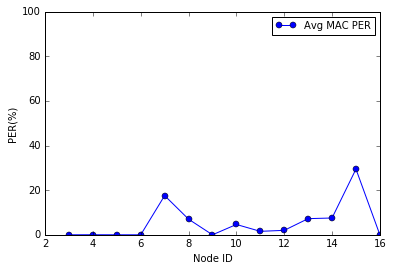

Min Application PER is 0.0 % for node 3
Max Application PER is 0.784267821608 % for node 15
Average of Network Application PER is 0.0663239506312 %
Distribution of Node's Application PER is 


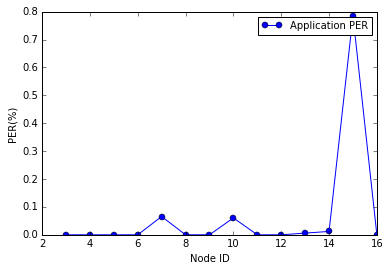

Min average Round Trip Time is 0 sec for node 16
Max average Round Trip Time is 5.53739269406 sec for node 15
Average of Network RTT is 3.24083866607 sec
Distribution of Node's RTT is 


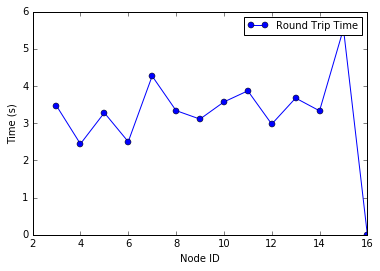

Number of Node Disconnections 0
Number of Topology Changes 0


In [7]:
appPer=[];
appFail=[];
appSent=[];

macPer=[];
macFail=[];
macSent=[];

avgRtt=[];
numDisconn=[];
numParentChange=[];

nodeId=[];

maxID = 14;
    
for i in range(0,maxID):
    prevAppTxFail=0;
    curAppTxFail=0;
    totalAppTxFail=0;
    
    prevAppTxTotal=0;
    curAppTxTotal=0;
    totalAppTxTotal=0;
    
    prevMacTxFail=0;
    curMacTxFail=0;
    totalMacTxFail=0;
    
    prevMacTxTotal=0;
    curMacTxTotal=0;
    totalMacTxTotal=0;

    id = i+3;
    
    tmp = df[(df['TIMESTAMP']>=START) & (df['TIMESTAMP']<=END) & (df['SENSOR_ID']==id)];
    tmp1 = df1[(df1['TIMESTAMP']>=START) & (df1['TIMESTAMP']<=END) & (df1['SENSOR_ID']==id)];
    tmp2 = df2[(df2['TIMESTAMP']>=START) & (df2['TIMESTAMP']<=END) & (df2['SENSOR_ID']==id)];
    
    appTxFail=tmp['APP_PER_LOST'];
    appTxTotal = tmp['APP_PER_SENT'];
    macTxFail=tmp['MAC_TX_NOACK'];
    macTxTotal=tmp['MAC_TX_TOTAL'];
    rtt=tmp1['RTT'];
    n1=tmp2['NUM_SYNC_LOST'];
    n2=tmp2['NUM_PARENT_CHANGE'];
    
    if (len(rtt)>0):
        avgRtt.append(sum(rtt)/len(rtt));
    else:
        avgRtt.append(0);
   
    if (len(n1)>0):
        l = len(n1.values);
        numDisconn.append(n1.values[l-1]-n1.values[0]);

        l = len(n2.values);
        numParentChange.append(n2.values[l-1]-n2.values[0]);
    else:
        numDisconn.append(0);
        numParentChange.append(0);
        
    
    if (len(appTxFail) >0):
        initVal= appTxFail.values[0];
        for item in appTxFail.values:
            prevAppTxFail = curAppTxFail;
            curAppTxFail = item;

            if (curAppTxFail-prevAppTxFail<0):
                totalAppTxFail +=prevAppTxFail;

        totalAppTxFail +=curAppTxFail;
        totalAppTxFail -=initVal;
        appFail.append(totalAppTxFail);

        initVal= appTxTotal.values[0];
        for item in appTxTotal.values:
            prevAppTxTotal = curAppTxTotal;
            curAppTxTotal = item;

            if (curAppTxTotal-prevAppTxTotal<0):
                totalAppTxTotal +=prevAppTxTotal;

        totalAppTxTotal +=curAppTxTotal;
        totalAppTxTotal -=initVal;
        appSent.append(totalAppTxTotal);
    else:
        appFail.append(0);
        appSent.append(1);
        
    
    if (len(macTxFail) >0):
        initVal= macTxFail.values[0];
        for item in macTxFail.values:
            prevMacTxFail = curMacTxFail;
            curMacTxFail = item;

            if (curMacTxFail-prevMacTxFail<0):
                totalMacTxFail +=prevMacTxFail;

        totalMacTxFail +=curMacTxFail;
        totalMacTxFail -=initVal;
        macFail.append(totalMacTxFail);

        initVal= macTxTotal.values[0];
        for item in macTxTotal.values:
            prevMacTxTotal = curMacTxTotal;
            curMacTxTotal = item;

            if (curMacTxTotal-prevMacTxTotal<0):
                totalMacTxTotal +=prevMacTxTotal;

        totalMacTxTotal +=curMacTxTotal;
        totalMacTxTotal -=initVal;
        macSent.append(totalMacTxTotal);
    else:
        macFail.append(0);
        macSent.append(1);
        
    nodeId.append(i+3);
    
for i in range(0,maxID):
    appPer.append(appFail[i]*100/(appSent[i]*1.0));
    macPer.append(macFail[i]*100/(macSent[i]*1.0));
    
minMacPer=min(macPer);
indexOfMinMacPer=macPer.index(minMacPer);
maxMacPer=max(macPer);
indexOfMaxMacPer=macPer.index(maxMacPer);

print "Min MAC PER is",minMacPer,"% for node",nodeId[indexOfMinMacPer];
print "Max MAC PER is",maxMacPer,"% for node",nodeId[indexOfMaxMacPer];
print "Average of Network MAC PER is",sum(macPer)/len(macPer),"%";

print "Distribution of Node's Average MAC PER is "
ax=plt.plot(nodeId,macPer,'-o',label='Avg MAC PER');
plt.ylim(0,100);
plt.legend(fontsize=10);
plt.xlabel("Node ID");
plt.ylabel("PER(%)");
plt.show();


minAppPer=min(appPer);
indexOfMinAppPer=appPer.index(minAppPer);
maxAppPer=max(appPer);
indexOfMaxAppPer=appPer.index(maxAppPer);

print "Min Application PER is",minAppPer,"% for node",nodeId[indexOfMinAppPer];
print "Max Application PER is",maxAppPer,"% for node",nodeId[indexOfMaxAppPer];
print "Average of Network Application PER is",sum(appPer)/len(appPer),"%";
   
print "Distribution of Node's Application PER is "
plt.plot(nodeId,appPer,'-o',label='Application PER');
plt.legend(fontsize=10);
plt.xlabel("Node ID");
plt.ylabel("PER(%)");
plt.show();

minRtt=min(avgRtt);
indexOfMinRtt=avgRtt.index(minRtt);
maxRtt=max(avgRtt);
indexOfMaxRtt=avgRtt.index(maxRtt);

print "Min average Round Trip Time is",minRtt,"sec for node",nodeId[indexOfMinRtt];
print "Max average Round Trip Time is",maxRtt,"sec for node",nodeId[indexOfMaxRtt];
print "Average of Network RTT is",sum(avgRtt)/len(avgRtt),"sec";

print "Distribution of Node's RTT is "
plt.plot(nodeId,avgRtt,'-o',label='Round Trip Time');
plt.legend(fontsize=10);
plt.xlabel("Node ID");
plt.ylabel("Time (s)");
plt.show();

print "Number of Node Disconnections",sum(numDisconn);
print "Number of Topology Changes",sum(numParentChange);


This is for Node specific performance analysis

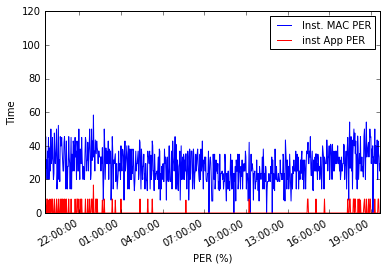

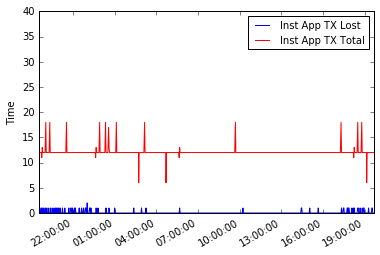

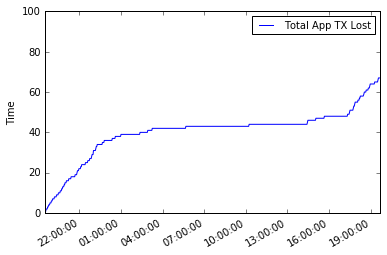

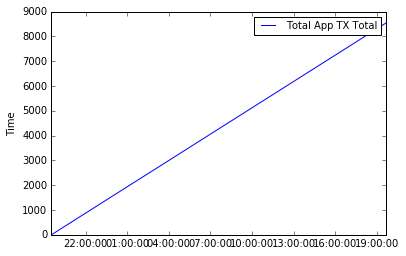

In [55]:
sensorId =15;

START1= pd.Timestamp('2018-01-24 08:00:00');
START1=START1.value/1000000;
END1 = pd.Timestamp('2018-01-30 00:00:00');
END1=END1.value/1000000;
#tmp3 = df[(df['TIMESTAMP']>=START1) & (df['TIMESTAMP']<=END1) & (df['SENSOR_ID']==sensorId)];
tmp3 = df[(df['TIMESTAMP']>=START) & (df['TIMESTAMP']<=END) & (df['SENSOR_ID']==sensorId)];


t = tmp3['TIMESTAMP'].values;
t=pd.to_datetime(t,unit='ms')
nodeMacTxFail=tmp3['MAC_TX_NOACK'];
nodeMacTxTotal=tmp3['MAC_TX_TOTAL'];
nodeAppTxFail=tmp3['APP_PER_LOST'];
nodeAppTxTotal=tmp3['APP_PER_SENT'];

nodeInstMacPER=nodeMacTxFail.diff()/nodeMacTxTotal.diff()*100;
nodeInstAppPER=nodeAppTxFail.diff()/nodeAppTxTotal.diff()*100;

plt.plot(t,nodeInstMacPER,label='Inst. MAC PER');
plt.plot(t,nodeInstAppPER,'r',label='inst App PER');
plt.ylim(0,120);
plt.gcf().autofmt_xdate();
plt.legend(fontsize=10);
plt.xlabel("PER (%)");
plt.ylabel("Time");
plt.show();


plt.plot(t,nodeAppTxFail.diff(),label='Inst App TX Lost');
plt.plot(t,nodeAppTxTotal.diff(),'r',label='Inst App TX Total');
plt.ylim(0,40);
plt.gcf().autofmt_xdate();
plt.legend(fontsize=10);
plt.xlabel("");
plt.ylabel("Time");
plt.show();

plt.plot(t,nodeAppTxFail ,label='Total App TX Lost');
#plt.plot(t,nodeAppTxTotal,'r',label='Total App TX Total');
plt.gcf().autofmt_xdate();
plt.ylim(0,100);
plt.legend(fontsize=10);
plt.xlabel("");
plt.ylabel("Time");
plt.show();

index=[];

for k in range(0,len(t)):
    index.append(k);
    
plt.plot(t,nodeAppTxTotal ,label='Total App TX Total');
#plt.plot(index,t,label='Total App TX Total');
#plt.gcf().autofmt_xdate();
plt.legend(fontsize=10);
plt.xlabel("");
plt.ylabel("Time");
plt.show();



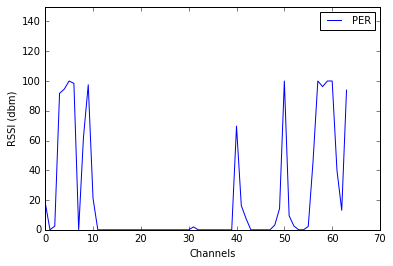

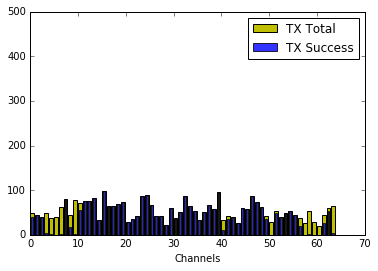

In [56]:
chInfo = tmp3['CHANNEL_INFO'];


chTxNoAck=[];
chTxTotal=[];
chTxSuccess=[];
chPER=[];
chRssi=[];
chCount=[];
channels=[];

instChPER=[];

maxChannel = 64;

for i in range(0,maxChannel):
    chTxNoAck.append(0);
    chTxTotal.append(0);
    chTxSuccess.append(0);
    chPER.append(0);
    chRssi.append(0);
    chCount.append(0);
    channels.append(i);
    instChPER.append([]);


for item in chInfo:
    ch = json.loads(item);

    for i in range(0,maxChannel):
        if (ch[str(i)]['txTotalPerCh']!=0):
            chTxNoAck[i]+=ch[str(i)]['txNoAckPerCh'];
            chTxTotal[i]+=ch[str(i)]['txTotalPerCh'];
            instChPER[i].append(ch[str(i)]['txNoAckPerCh']/(ch[str(i)]['txTotalPerCh']*1.0)*100);
            if (ch[str(i)]['rssi']!=0):
                chRssi[i]+=ch[str(i)]['rssi'];
                chCount[i]+=1;
        else:
            instChPER[i].append(0);
        
            
for i in range(0,maxChannel):
    if (chCount[i] > 0):
        chPER[i]=chTxNoAck[i]/(chTxTotal[i]*1.0)*100;
        chRssi[i]=chRssi[i]/(chCount[i]*1.0);
        chTxSuccess[i]=chTxTotal[i]-chTxNoAck[i];
    else:
        chPER[i]=100;
        chRssi[i]=-100;
        
        

channels_2P4G=[];
chPER_2P4G=[];
chRssi_2P4G=[];
instChPER_2P4G=[]

for i in range(11,27):
    channels_2P4G.append(i);
    chPER_2P4G.append(chPER[i]);
    chRssi_2P4G.append(chRssi[i]);
    instChPER_2P4G.append(instChPER[i]);
    
if 1:
    plt.plot(channels,chPER,label='PER');
    #plt.plot(channels,chRssi,'r',label='RSSI');
    #plt.plot(channels_2P4G,chPER_2P4G,label='PER');
    #plt.plot(channels_2P4G,chRssi_2P4G,'r',label='RSSI');
    plt.legend(fontsize=10);
    plt.ylim(0,150);
    plt.xlabel("Channels");
    plt.ylabel("RSSI (dbm)");
    plt.show();

if 0:
    fig, ax1 = plt.subplots()
    ax1.plot(channels,chPER);
    ax1.set_xlabel('Channels')
    ax1.set_ylabel('PER', color='b')
    ax1.tick_params('y', colors='b')

    #ax2 = ax1.twinx()
    #ax2.plot(channels,chRssi,'r')
    #ax2.set_ylabel('RSSI', color='r')
    #ax2.tick_params('y', colors='r')
    #fig.tight_layout()
    plt.show()


width=0.8;
plt.bar(channels,chTxTotal,width,color='y',label='TX Total');
plt.bar([i+0.25*width for i in channels],chTxSuccess,width=0.5*width,color='b',alpha=0.8,label='TX Success');
plt.legend(fontsize=10);
plt.legend()
plt.ylim(0,500);
plt.xlabel("Channels");
plt.show();

if (0):   
    plt.plot(t,instChPER_2P4G[0],'o',label='CH11');
    plt.plot(t,instChPER_2P4G[1],'^',label='CH12');
    plt.plot(t,instChPER_2P4G[2],'*',label='CH13');
    plt.plot(t,instChPER_2P4G[3],'+',label='CH14');
    plt.plot(t,instChPER_2P4G[4],'o',label='CH15');
    plt.plot(t,instChPER_2P4G[5],'^',label='CH16');
    plt.plot(t,instChPER_2P4G[6],'*',label='CH17');
    plt.plot(t,instChPER_2P4G[7],'+',label='CH18');
    plt.gcf().autofmt_xdate();
    plt.legend(fontsize=6);
    plt.ylim(0,200);
    plt.xlabel("Time");
    plt.ylabel("PER");
    plt.show();

    plt.plot(t,instChPER_2P4G[8],'o',label='CH19');
    plt.plot(t,instChPER_2P4G[9],'^',label='CH20');
    plt.plot(t,instChPER_2P4G[10],'*',label='CH21');
    plt.plot(t,instChPER_2P4G[11],'+',label='CH22');
    plt.plot(t,instChPER_2P4G[12],'o',label='CH23');
    plt.plot(t,instChPER_2P4G[13],'^',label='CH24');
    plt.plot(t,instChPER_2P4G[14],'*',label='CH25');
    plt.plot(t,instChPER_2P4G[15],'+',label='CH26');
    plt.gcf().autofmt_xdate();
    plt.legend(fontsize=6);
    plt.ylim(0,200);
    plt.xlabel("Time");
    plt.ylabel("PER");
    plt.show();